<a href="https://colab.research.google.com/github/NadiaLayraAziza/Skripsi_Nadia_2023/blob/main/Skripsi_Nadia_Progres_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from skimage import color
from skimage import io
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re

In [ ]:
## Function to plot multiple images
def plot_img(images, titles):
  fig, axs = plt.subplots(nrows = 1, ncols = len(images), figsize = (15, 15))
  for i, p in enumerate(images):
    axs[i].imshow(p, 'gray')
    axs[i].set_title(titles[i])
    #axs[i].axis('off')
  plt.show()

Loop: 5.735874176025391 ms


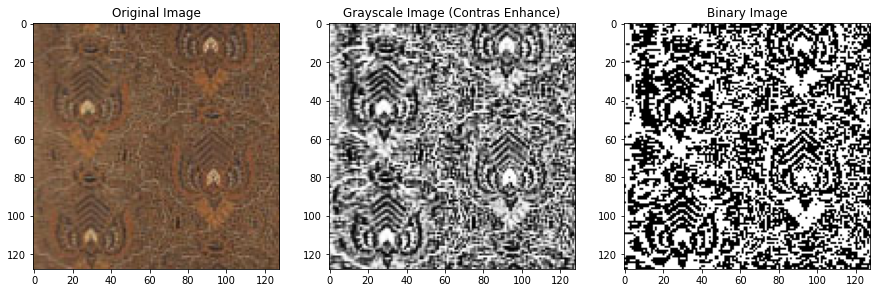

In [ ]:
# Import the image in grayscale
img = cv2.imread("/content/drive/MyDrive/SKRIPSI/Dataset/Cuwiri/B39_1.jpg")
image_ori = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Grayscale with matrix multiply
ts = time.time()
w = np.array([[[ 0.1141, 0.5870, 0.2989]]])
grayscale = cv2.convertScaleAbs(np.sum(img*w, axis=2))
t = (time.time() -ts)
print("Loop: {:} ms".format(t*1000))

# Contras Enhance for grayscale
gray_img_eqhist = cv2.equalizeHist(grayscale)
clahe=cv2.createCLAHE(clipLimit=40)
gray_img_clahe=clahe.apply(gray_img_eqhist)

# Binary with Otsu's thresholding
ret,img_otsu_binary = cv2.threshold(gray_img_clahe,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Plot the images
images = [image_ori, gray_img_clahe, img_otsu_binary]
titles = ['Original Image', 'Grayscale Image (Contras Enhance)', 'Binary Image']
plot_img(images, titles)

In [17]:
# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")
        

# -------------------- Load Dataset ------------------------
 
dataset_dir = "/content/drive/MyDrive/SKRIPSI" 

imgs = [] #list image matrix
img_binary = [] 
dump = []
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            
            # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ## Grayscale with matrix multiply
            ts = time.time()
            w = np.array([[[ 0.1141, 0.5870, 0.2989]]])
            grayscale = cv2.convertScaleAbs(np.sum(img*w, axis=2))
            t = (time.time() -ts)
            # print("Loop: {:} ms".format(t*1000))

            # Contras Enhance for grayscale
            gray_img_eqhist = cv2.equalizeHist(grayscale)
            clahe=cv2.createCLAHE(clipLimit=40)
            gray=clahe.apply(gray_img_eqhist)

            # Binary with Otsu's thresholding
            ret,img_otsu_binary = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

            hu = cv2.HuMoments(cv2.moments(img_otsu_binary))

            for i in range(0, 7):
              hu[i] = -1 * np.sign(hu[i]) * np.log10(np.abs(hu[i]))
            
            # h, w = gray.shape
            # ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
            # crop = gray[ymin:ymax, xmin:xmax]
            
            # resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
            
            # imgs.append(resize)
            imgs.append(gray)
            img_binary.append(img_otsu_binary)
            labels.append(normalize_label(os.path.splitext(filename)[0]))
            descs.append(normalize_desc(folder, sub_folder))

            hu = hu.reshape((1, 7)).tolist()[0] + [filename]
            dump.append(hu)
            
            print_progress(i, len_sub_folder, folder, sub_folder, filename)

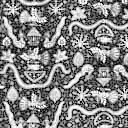

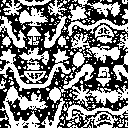

In [18]:
from google.colab.patches import cv2_imshow
cv2_imshow(imgs[5])
cv2_imshow(img_binary[5])

In [12]:
from skimage.feature import greycomatrix, greycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/fea

In [13]:
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

# glcm_df.head()
glcm_df

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,78.259464,80.112643,78.413046,81.480359,0.085441,0.053969,0.075983,0.021581,0.014102,0.012939,...,10045.724246,0.000048,0.000048,0.000048,0.000049,0.006905,0.006954,0.006949,0.006969,B161
1,76.867632,81.042924,80.140689,81.481074,0.106666,0.027882,0.042736,0.024347,0.014560,0.013057,...,10037.996423,0.000048,0.000049,0.000048,0.000049,0.006931,0.007014,0.006930,0.006966,B162
2,77.300305,79.289347,78.588796,81.714945,0.094606,0.068205,0.071442,0.017611,0.014412,0.012962,...,10047.040127,0.000047,0.000049,0.000049,0.000049,0.006881,0.007007,0.006969,0.006976,B163
3,79.419588,81.133260,79.349657,83.167599,0.053964,0.035806,0.060799,-0.004675,0.014724,0.011161,...,10327.492521,0.000048,0.000048,0.000048,0.000048,0.006924,0.006963,0.006908,0.006937,B164
4,78.685595,81.761186,78.675813,82.297151,0.080960,0.028510,0.080775,0.019463,0.014210,0.013584,...,10158.042469,0.000048,0.000049,0.000049,0.000049,0.006926,0.006985,0.006965,0.006964,B165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,82.885480,82.962279,83.263529,84.046176,0.023133,0.023933,0.011625,0.008433,0.013273,0.012337,...,10559.765479,0.000048,0.000049,0.000048,0.000048,0.006925,0.006968,0.006919,0.006946,B392
296,82.051131,83.086563,83.681911,83.122854,0.043542,0.029759,0.012693,0.027095,0.014500,0.012320,...,10386.357895,0.000048,0.000048,0.000049,0.000048,0.006926,0.006949,0.006973,0.006958,B393
297,81.671494,82.835653,82.122523,83.840466,0.046243,0.028013,0.040192,0.013336,0.014960,0.012895,...,10475.920721,0.000048,0.000049,0.000048,0.000049,0.006930,0.006972,0.006896,0.006980,B394
298,83.851308,83.419225,83.419525,83.548127,0.015076,0.019332,0.017963,0.022179,0.013385,0.012207,...,10466.892170,0.000047,0.000049,0.000048,0.000048,0.006883,0.006965,0.006899,0.006944,B395


In [16]:
cols = ["hu1", "hu2", "hu3", "hu4", "hu5", "hu6", "hu7", "label"]
	
mi_df = pd.DataFrame(dump, columns=cols)
mi_df

# print("Extraction done!")

,hu1,hu2,hu3,hu4,hu5,hu6,hu7,label
0,2.871790,10.532270,12.393055,12.748444,-26.002743,-18.333662,-25.328725,B16_1.jpg
1,2.886285,9.902556,12.014810,13.345903,-26.382192,18.352853,26.073132,B16_2.jpg
2,2.876979,10.139924,12.743230,13.981773,-27.351822,19.137403,-28.077501,B16_3.jpg
3,2.886469,9.946347,11.753544,13.401661,-26.125455,-18.375893,-26.134190,B16_4.jpg
4,2.881999,9.506998,12.629859,13.733444,27.945704,20.099347,26.916990,B16_5.jpg
...,...,...,...,...,...,...,...,...
295,2.893035,10.314000,12.394841,13.624988,27.423078,-18.816364,-26.640740,B39_2.jpg
296,2.890298,9.679791,12.513052,13.445458,26.545653,-18.545883,-26.609476,B39_3.jpg
297,2.890555,10.304843,13.316913,13.143726,-27.010107,19.495120,-26.385971,B39_4.jpg
298,2.888672,11.279638,13.213764,13.620044,-27.065519,-19.283827,27.491486,B39_5.jpg
